STEP 5

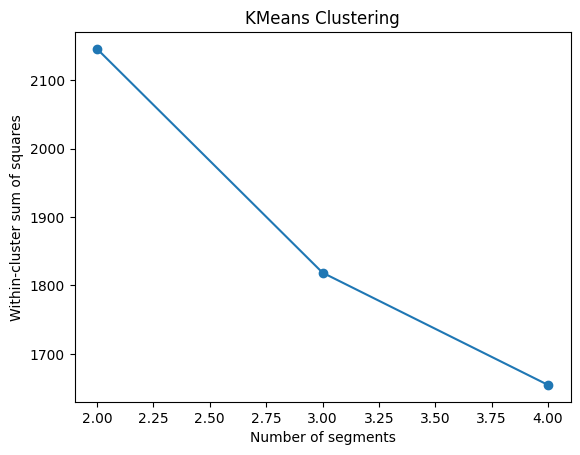

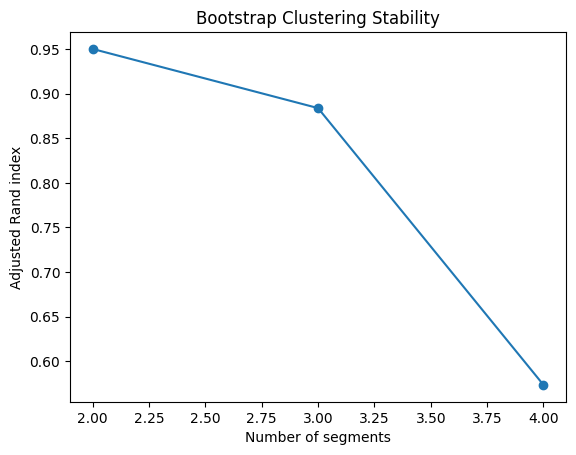

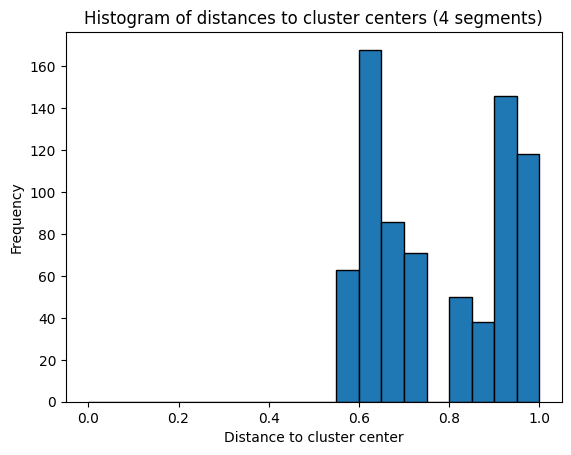

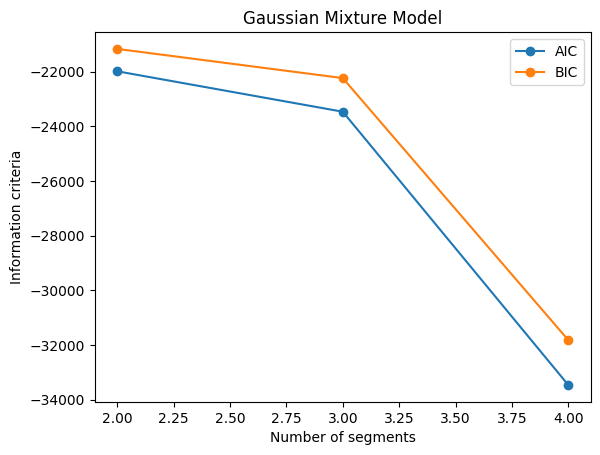

Confusion Matrix between KMeans and GMM:
[[  3 103  58 339]
 [ 18 310   1  30]
 [ 16 141   0 169]
 [ 92  44  15 114]]
Confusion Matrix between KMeans and GMM (KMeans initialization):
[[  3 103  58 339]
 [ 18 310   1  30]
 [ 16 141   0 169]
 [ 92  44  15 114]]
Log-Likelihood of GMM: 17040.598827012964
Log-Likelihood of GMM (KMeans initialization): 17040.598827012964


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix

# Load the dataset
file_path = '/content/drive/MyDrive/Code Conversion/mcdonalds.csv'
mcdonalds = pd.read_csv(file_path)

# Convert the first 11 columns to a binary matrix
MD_x = mcdonalds.iloc[:, 0:11]
MD_x_binary = (MD_x == "Yes").astype(int)

# Set the seed for reproducibility
np.random.seed(1234)

# Perform KMeans clustering for 2 to 5 clusters (reduced range)
n_clusters = range(2, 5)
n_repeats = 5
clusterings = []

for k in n_clusters:
    best_inertia = np.inf
    best_kmeans = None
    for _ in range(n_repeats):
        kmeans = KMeans(n_clusters=k, n_init=5, random_state=1234).fit(MD_x_binary)
        if kmeans.inertia_ < best_inertia:
            best_inertia = kmeans.inertia_
            best_kmeans = kmeans
    clusterings.append(best_kmeans)

# Plot the clustering results (within-cluster sum of squares)
inertias = [km.inertia_ for km in clusterings]
plt.plot(n_clusters, inertias, marker='o')
plt.xlabel('Number of segments')
plt.ylabel('Within-cluster sum of squares')
plt.title('KMeans Clustering')
plt.show()

# Perform bootstrap resampling and calculate the adjusted Rand index
n_bootstraps = 10
rand_indices = np.zeros((len(n_clusters), n_bootstraps))

for i, k in enumerate(n_clusters):
    kmeans = clusterings[i]
    for j in range(n_bootstraps):
        X_resampled, y_resampled = resample(MD_x_binary, kmeans.labels_, random_state=1234 + j)
        kmeans_resampled = KMeans(n_clusters=k, n_init=5, random_state=1234).fit(X_resampled)
        rand_indices[i, j] = adjusted_rand_score(y_resampled, kmeans_resampled.labels_)

# Plot the adjusted Rand index for clustering stability
mean_rand_indices = rand_indices.mean(axis=1)
plt.plot(n_clusters, mean_rand_indices, marker='o')
plt.xlabel('Number of segments')
plt.ylabel('Adjusted Rand index')
plt.title('Bootstrap Clustering Stability')
plt.show()

# Select the clustering result for 4 segments
best_kmeans_4 = clusterings[n_clusters.index(4)]

# Plot histogram of distances to cluster centers for the 4-segment clustering
distances = best_kmeans_4.transform(MD_x_binary)
min_distances = np.min(distances, axis=1)
plt.hist(min_distances, bins=20, range=(0, 1), edgecolor='black')
plt.xlabel('Distance to cluster center')
plt.ylabel('Frequency')
plt.title('Histogram of distances to cluster centers (4 segments)')
plt.show()

# Mixture model clustering using GaussianMixture
# Perform Gaussian Mixture Model for 2 to 5 components (reduced range)
mixtures = []

for k in n_clusters:
    gmm = GaussianMixture(n_components=k, n_init=5, random_state=1234).fit(MD_x_binary)
    mixtures.append(gmm)

# Plot AIC and BIC for mixture models
aics = [gmm.aic(MD_x_binary) for gmm in mixtures]
bics = [gmm.bic(MD_x_binary) for gmm in mixtures]

plt.plot(n_clusters, aics, label='AIC', marker='o')
plt.plot(n_clusters, bics, label='BIC', marker='o')
plt.xlabel('Number of segments')
plt.ylabel('Information criteria')
plt.title('Gaussian Mixture Model')
plt.legend()
plt.show()

# Select the best GMM model for 4 components
best_gmm_4 = mixtures[n_clusters.index(4)]

# Compare clustering results from KMeans and GMM
kmeans_labels = best_kmeans_4.labels_
gmm_labels = best_gmm_4.predict(MD_x_binary)

conf_matrix = confusion_matrix(kmeans_labels, gmm_labels)
print("Confusion Matrix between KMeans and GMM:")
print(conf_matrix)

# Fit a GMM with KMeans initialization
best_gmm_kmeans_init = GaussianMixture(n_components=4, n_init=5, random_state=1234, init_params='kmeans').fit(MD_x_binary)

# Compare clustering results with GMM (KMeans init)
gmm_kmeans_init_labels = best_gmm_kmeans_init.predict(MD_x_binary)
conf_matrix_kmeans_init = confusion_matrix(kmeans_labels, gmm_kmeans_init_labels)
print("Confusion Matrix between KMeans and GMM (KMeans initialization):")
print(conf_matrix_kmeans_init)

# Log-Likelihood of the models
log_likelihood_gmm = best_gmm_4.score(MD_x_binary) * MD_x_binary.shape[0]
log_likelihood_gmm_kmeans_init = best_gmm_kmeans_init.score(MD_x_binary) * MD_x_binary.shape[0]

print("Log-Likelihood of GMM:", log_likelihood_gmm)
print("Log-Likelihood of GMM (KMeans initialization):", log_likelihood_gmm_kmeans_init)
